In [1]:
#Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import init_notebook_mode,plot,iplot,download_plotlyjs
import pandas_profiling as pp
import matplotlib.patches as pa
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import (precision_score,recall_score,classification_report,f1_score,roc_auc_score,accuracy_score,roc_curve,
average_precision_score,confusion_matrix)
import collections
from collections import Counter
from sklearn.model_selection import cross_val_predict,RandomizedSearchCV
from sklearn.externals import joblib

In [2]:
cf.go_offline()
init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
#Load data
cr=pd.read_csv('datasets/creditcard.csv')

In [4]:
#Basic EDA using pandas profiler
pp.ProfileReport(cr)

1.Dataset has 31 feaures. 30 are numeric and one is boolean

2.We have no missing values

3.We have 1081 duplicate rows

4.Principal Component Analysis has been applied to V1 to V28.

5.The feature time represents time elapsed since previous tansaction

6.Only feature Amount and Class are in their original form

# 2.Univarite analysis 

## 2.1 Class 

In [5]:
#Value count for each category as a percentage
cr['Class'].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

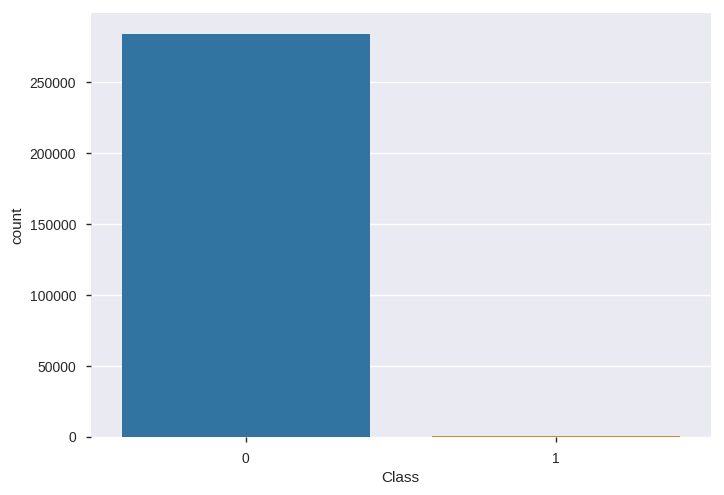

In [6]:
#Countplot for the classes
sns.countplot(x='Class',data=cr)

1.This is an imbalanced dataset


2.99.8% of cases are not fraud and 0.2 are fraud

## 2.2 Amount

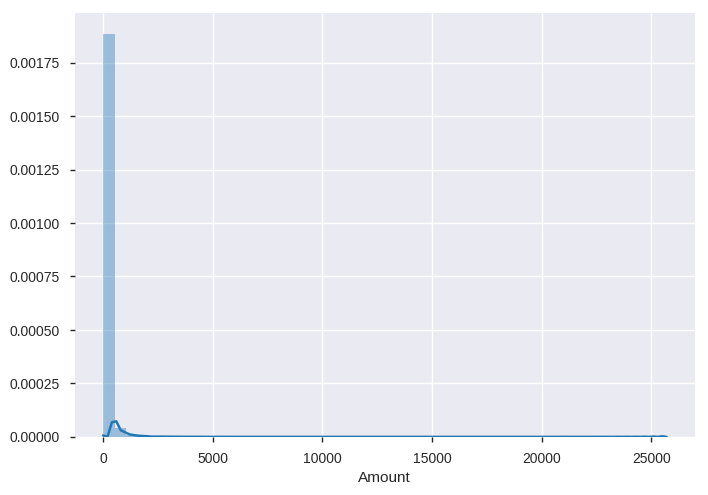

In [7]:
#distplot
sns.distplot(cr['Amount'],kde=True)

1.From the profile report the mean amount is 88.35

2.The kurtosis is 845.09

3.The skew is 16.978 which means it is highly skewed to the right

4.The minimum amount is 0

# 3 Pre-processing

## 3.1 Remove duplicates

In [8]:
#Remove duplicate rows
cr.drop_duplicates(inplace=True)

## 3.2 Scaling 

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
sc=StandardScaler()

In [11]:
#Scale values to mean of 0 and standard deviation of 1
cr['scaled_amount']=sc.fit_transform(cr['Amount'].values.reshape(-1,1))
cr['scaled_time']=sc.fit_transform(cr['Time'].values.reshape(-1,1))

In [12]:
#Drop Amount and Time
cr.drop(['Amount','Time'],axis=1,inplace=True)

In [13]:
#Check if time and amount have been scaled
cr[['scaled_amount','scaled_time']].head()

scaled_amount  scaled_time
0       0.244200    -1.996823
1      -0.342584    -1.996823
2       1.158900    -1.996802
3       0.139886    -1.996802
4      -0.073813    -1.996781

## 3.3 Splitting

Stratified k-fold validation will be used to ensure the target class has almost equal counts

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
skf=StratifiedKFold(n_splits=5)

In [16]:
#Create features and the target
x=cr.drop(['Class'],axis=1)
y=cr['Class']

In [17]:
for train_index,test_index in skf.split(x,y):
    original_xtrain,original_xtest=x.iloc[train_index],x.iloc[test_index]
    original_ytrain,original_ytest=y.iloc[train_index],y.iloc[test_index]
    
original_xtrain=original_xtrain.values
original_xtest=original_xtest.values
original_ytrain=original_ytrain.values
original_ytest=original_ytest.values

In [18]:
#Check if train and test are distributed as per original dataset
train_labels,train_count=np.unique(original_ytrain,return_counts=True)
test_labels,test_count=np.unique(original_ytest,return_counts=True)
print('Label Distribution')
print(train_count/len(original_ytrain))
print(test_count/len(original_ytest))

Label Distribution
[0.99833026 0.00166974]
[0.99834344 0.00165656]


The distribution of the classes are close to that of the original dataset

# 4.0 RANDOM UNDERSAMPLING

Random undersampling is one of the ways of dealing with imbalanced datasets  where the majority class in our case 

non fraud cases are undersampled.This will result in 50% fraud cases and 50% non-fraud cases. One throwback with 

undersampling is the loss of information

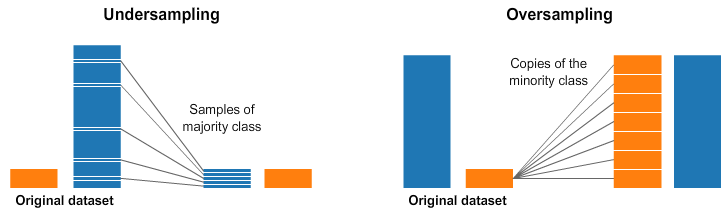

In [19]:
from IPython.display import Image
Image(filename='images/undersampling.png')

In [20]:
cr['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

In [21]:
#Categorize cases the undersample non fraud cases to 473
fraud_cases=cr[cr['Class']==1]
not_fraud=cr[cr['Class']==0][:473]

In [22]:
#Concatenate along axis 0
equal_distribution=pd.concat([fraud_cases,not_fraud])

Text(0.5, 1.0, 'Distribution of fraud and non fraud cases in new dataframe')

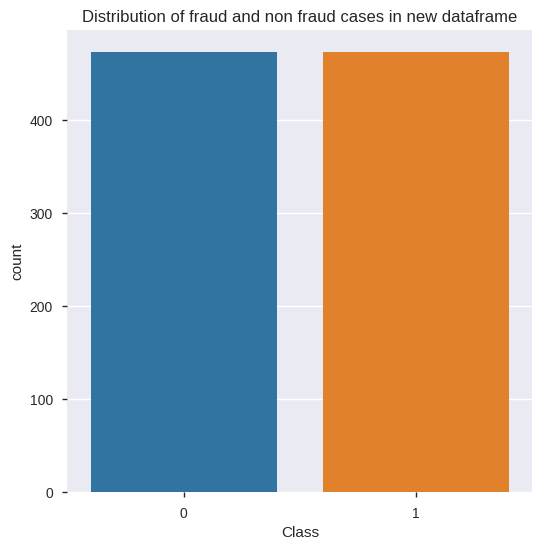

In [23]:
plt.figure(figsize=(6,6))
sns.countplot(x='Class',data=equal_distribution)
plt.title('Distribution of fraud and non fraud cases in new dataframe')

In [24]:
#Shuffle the set
from sklearn.utils import shuffle
new=shuffle(equal_distribution)

In [25]:
new.head()

V1        V2        V3        V4        V5        V6        V7  \
46909 -4.075975  0.963031 -5.076070  4.955963 -0.161437 -2.832663 -7.619765   
6903  -2.535852  5.793644 -7.618463  6.395830 -0.065210 -3.136372 -3.104557   
246   -0.827465  1.248570  1.023826  0.618081  0.191094 -0.208733  0.964715   
257   -0.723637  0.154496  1.263163  0.964978 -0.027170  2.285202  1.891703   
353    1.455906 -0.928378  0.353459 -1.377867 -1.233133 -0.600292 -0.817626   

             V8        V9       V10     ...            V22       V23  \
46909  1.618895 -2.992092 -7.142199     ...       0.165328 -1.017502   
6903   1.823233 -3.878658 -7.297803     ...      -0.448060 -0.402407   
246   -0.139166 -0.625848  0.427322     ...      -0.947557  0.135054   
257   -0.141478 -0.110655 -0.147587     ...       0.424114  0.206428   
353   -0.185507 -2.053665  1.362870     ...      -0.468314  0.119445   

            V24       V25       V26       V27       V28  Class  scaled_amount  \
46909 -0.477983 -0.304987 -0.106089  1.899714  0.511462      1      -0.349333   
6903  -0.288835  1.011752  0.425965  0.413140  0.308205      1      -0.349333   
246   -0.074105 -0.732006 -0.943678 -0.649289 -0.368765      0      -0.176809   
257   -0.966411 -0.761682 -0.437223 -0.051109 -0.380738      0       0.918643   
353    0.052555  0.255276 -0.313338  0.044343  0.022091      0      -0.247496   

       scaled_time  
46909    -1.091513  
6903     -1.809674  
246      -1.993306  
257      -1.993011  
353      -1.991347  

[5 rows x 31 columns]

## 4.1 Visualizations 

### 4.1.1 Correlation matrix

Text(0.5, 1.0, 'correlation matrix')

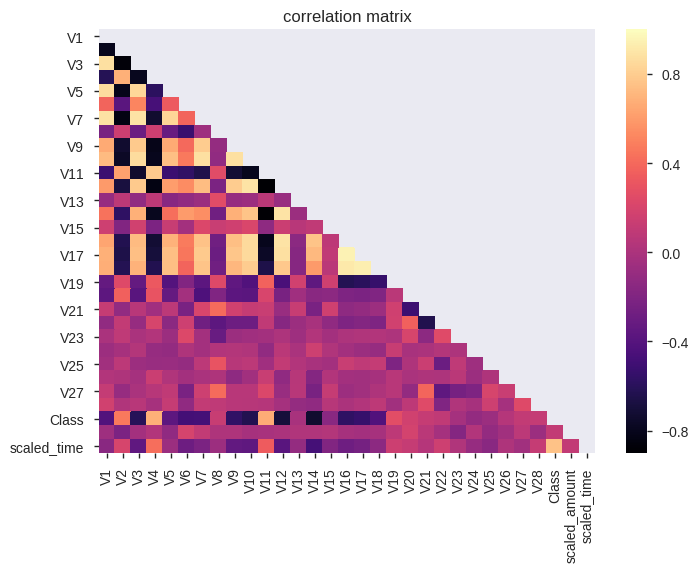

In [26]:
#Heatmap
corr=new.corr()
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
ax=sns.heatmap(corr,mask=mask,cmap='magma')
ax.set_title('correlation matrix')

1.V3,V10,V12 and V14 are negatively correlated with class.We can investigate them further using boxplots

## 4.1.2 Boxplots 

Text(0.5, 1.0, 'V14 and class negative')

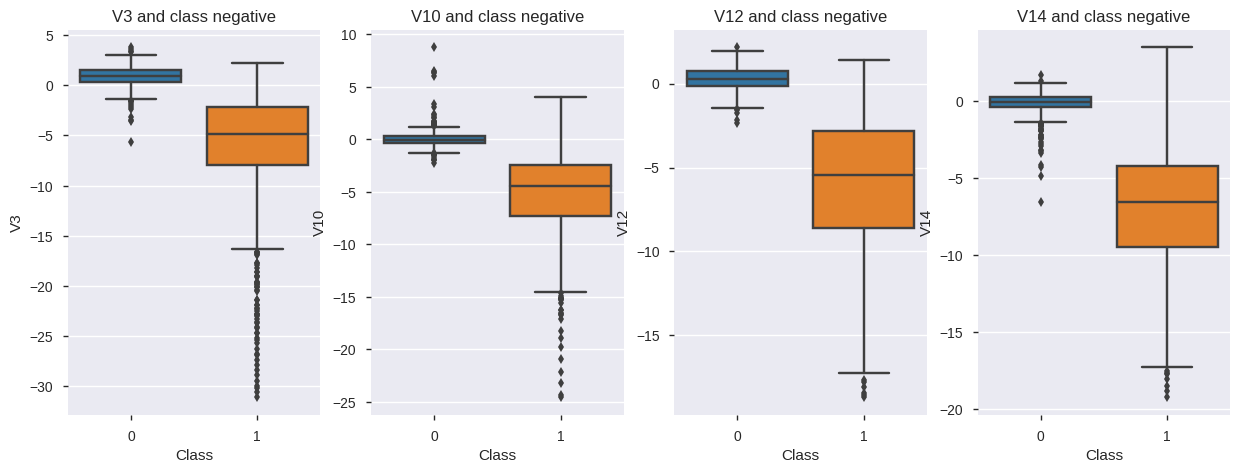

In [27]:
#Boxplot for negative correlations with class
fig,ax=plt.subplots(ncols=4,figsize=(15,5))
sns.boxplot(x='Class',y='V3',data=new,ax=ax[0])
ax[0].set_title('V3 and class negative')
sns.boxplot(x='Class',y='V10',data=new,ax=ax[1])
ax[1].set_title('V10 and class negative')
sns.boxplot(x='Class',y='V12',data=new,ax=ax[2])
ax[2].set_title('V12 and class negative')
sns.boxplot(x='Class',y='V14',data=new,ax=ax[3])
ax[3].set_title('V14 and class negative')

Text(0.5, 1.0, 'V11')

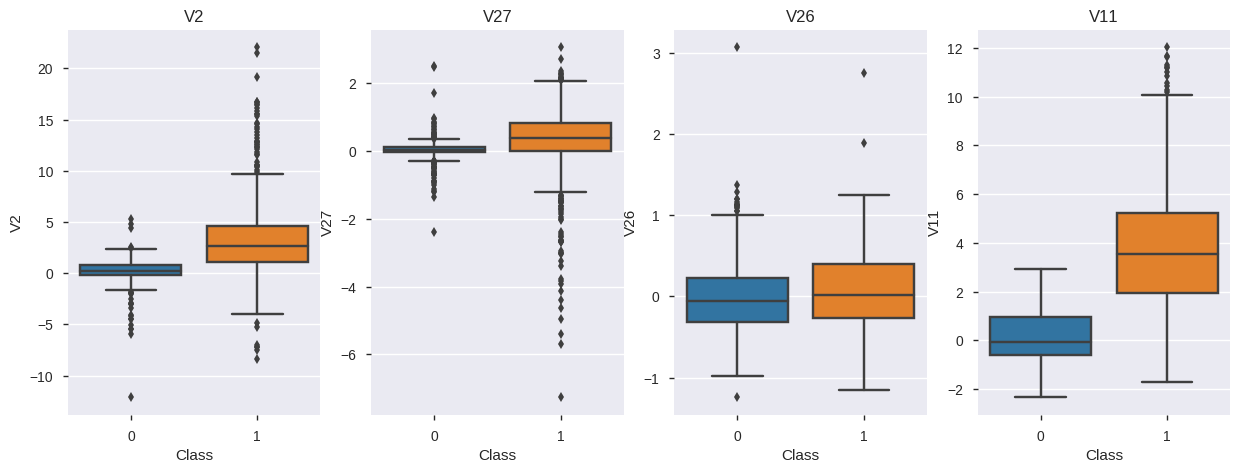

In [28]:
#Boxplot for positive correlations with class
fig,ax=plt.subplots(ncols=4,figsize=(15,5))
sns.boxplot(x='Class',y='V2',data=new,ax=ax[0])
ax[0].set_title('V2')
sns.boxplot(x='Class',y='V27',data=new,ax=ax[1])
ax[1].set_title('V27')
sns.boxplot(x='Class',y='V26',data=new,ax=ax[2])
ax[2].set_title('V26')
sns.boxplot(x='Class',y='V11',data=new,ax=ax[3])
ax[3].set_title('V11')

1.The lower the values the higher the probability of a fraud case

2.The higher the values the lower the probability of a fraud case

3.There are features present with extreme outliers

## 4.2 Outlier Removal 

1.Outliers for V10,V12 and V14 will be removed

In [29]:
'''Find the upper and lower percentiles for 
V10 compute the interquatile range then drop the outliers'''
v10_fraud=new['V10'].loc[new['Class']==1].values
q1=np.percentile(v10_fraud,25)
q2=np.percentile(v10_fraud,75)
iqr=q2-q1
print('Interquatile for V10 is',iqr)
cutt_off=iqr*1.5
v10_upper=q2+cutt_off
v10_lower=q1-cutt_off
new.drop(new[(new['V10']<v10_lower)|(new['V10']>v10_upper)].index,inplace=True)


Interquatile for V10 is 4.850334094903101


In [30]:
'''Find the upper and lower percentiles for 
V12 compute the interquatile range then drop the outliers'''
v12_fraud=new['V12'].loc[new['Class']==1].values
q1=np.percentile(v12_fraud,25)
q2=np.percentile(v12_fraud,75)
iqr=q2-q1
print('Interquatile for V12 is',iqr)
cutt_off=iqr*1.5
v12_upper=q2+cutt_off
v12_lower=q1-cutt_off
new.drop(new[(new['V12']<v12_lower)|(new['V12']>v12_upper)].index,inplace=True)


Interquatile for V12 is 5.227271614257905


In [31]:
'''Find the upper and lower percentiles for 
V14 compute the interquatile range then drop the outliers'''
v14_fraud=new['V14'].loc[new['Class']==1].values
q1=np.percentile(v14_fraud,25)
q2=np.percentile(v14_fraud,75)
iqr=q2-q1
print('Interquatile for V14 is',iqr)
cutt_off=iqr*1.5
v14_upper=q2+cutt_off
v14_lower=q1-cutt_off
new.drop(new[(new['V14']<v14_lower)|(new['V14']>v14_upper)].index,inplace=True)


Interquatile for V14 is 4.822366746269639


In [32]:
#New shape
new.shape

(900, 31)

## 4.3 Clustering 

We will cluster to see if advanced classification algorithms

will be able to seperate fraud from non-fraud cases

### 4.3.1 PCA 

In [33]:
from sklearn.decomposition import PCA

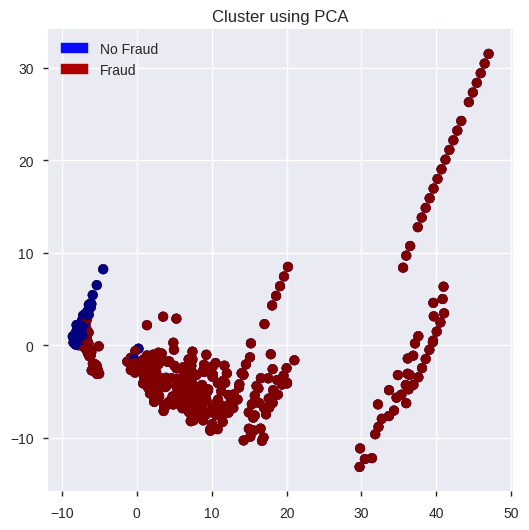

In [34]:
'''Cluster using PCA with two componentd'''
pca=PCA(n_components=2)
new_pca=pca.fit_transform(new)
plt.figure(figsize=(6,6))
plt.scatter(new_pca[:,0],new_pca[:,1],c=new['Class']==0,cmap='jet',label='No fraud')
plt.scatter(new_pca[:,0],new_pca[:,1],c=new['Class']==1,cmap='jet',label='fraud')
plt.title('Cluster using PCA')
blue_patch = pa.Patch(color='#0A0AFF', label='No Fraud')
red_patch = pa.Patch(color='#AF0000', label='Fraud')
plt.legend(handles=[blue_patch,red_patch])

In [35]:
#Explained variance for PCA
pca.explained_variance_ratio_.cumsum()

array([0.70658989, 0.80271887])

### 4.3.2 TSNE 

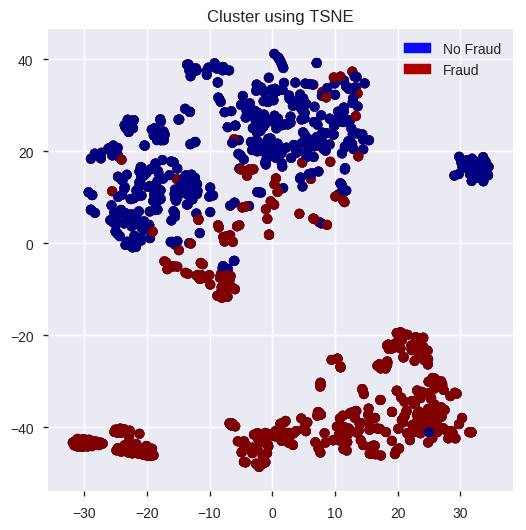

In [36]:
tsne=TSNE(n_components=2)
new_tsne=tsne.fit_transform(new)
plt.figure(figsize=(6,6))
plt.scatter(new_tsne[:,0],new_tsne[:,1],c=new['Class']==0,cmap='jet',label='No fraud')
plt.scatter(new_tsne[:,0],new_tsne[:,1],c=new['Class']==1,cmap='jet',label='fraud')
plt.title('Cluster using TSNE')
blue_patch = pa.Patch(color='#0A0AFF', label='No Fraud')
red_patch = pa.Patch(color='#AF0000', label='Fraud')
plt.legend(handles=[blue_patch,red_patch])

## 4.4 Modelling 

In [37]:
#Split dataset
x=new.drop('Class',axis=1)
y=new['Class']
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve,ShuffleSplit
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.8,random_state=43)

In [38]:
#Try different classifiers
classifiers={'LogisticRegression':LogisticRegression(),
            'DecisionTree':DecisionTreeClassifier(),
            'SVC':SVC(),
            'KNeigbor':KNeighborsClassifier(),
            'RandomForest':RandomForestClassifier(),
            'Bayes':GaussianNB()}

for key,classifier in classifiers.items():
    classifier.fit(xtrain,ytrain)
    training_score=cross_val_score(classifier,xtrain,ytrain,cv=5)
    print('Classifier', type(classifier).__name__,'has an acc val of',round(training_score.mean(),2))

Classifier LogisticRegression has an acc val of 0.95
Classifier DecisionTreeClassifier has an acc val of 1.0
Classifier SVC has an acc val of 0.92
Classifier KNeighborsClassifier has an acc val of 0.92
Classifier RandomForestClassifier has an acc val of 0.96
Classifier GaussianNB has an acc val of 0.97


1.Decision Tree has the maximum accuracy but its a sign of overfitting

2.It is followed by Random forest and bayes with 98%

3.The third is Logistic Regression

4.The fourth is SVC and finally KNeighbors

In [39]:
log_pred=cross_val_predict(classifiers['LogisticRegression'], xtrain, ytrain, cv=5,
                             method="decision_function")
dt_pred=cross_val_predict(classifiers['DecisionTree'], xtrain, ytrain, cv=5,
                            )
svc_pred=cross_val_predict(classifiers['SVC'], xtrain, ytrain, cv=5,
                             method="decision_function")
k_pred=cross_val_predict(classifiers['KNeigbor'], xtrain, ytrain, cv=5,
                             )
rf_pred=cross_val_predict(classifiers['RandomForest'], xtrain, ytrain, cv=5,
                            )
Gb_pred=cross_val_predict(classifiers['Bayes'], xtrain, ytrain, cv=5,
                            )

In [40]:
#compute roc auc scores for all classifiers
print('Logistic Regression: ', roc_auc_score(ytrain, log_pred))
print('KNears Neighbors: ', roc_auc_score(ytrain, k_pred))
print('Support Vector Classifier: ', roc_auc_score(ytrain, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(ytrain, dt_pred))
print('Bayes Classifier: ', roc_auc_score(ytrain, Gb_pred))
print('Random forest Classifier: ', roc_auc_score(ytrain, rf_pred))

Logistic Regression:  0.9920358387257342
KNears Neighbors:  0.91052762568442
Support Vector Classifier:  0.9766052762568441
Decision Tree Classifier:  1.0
Bayes Classifier:  0.9693877551020409
Random forest Classifier:  0.9369089099054255


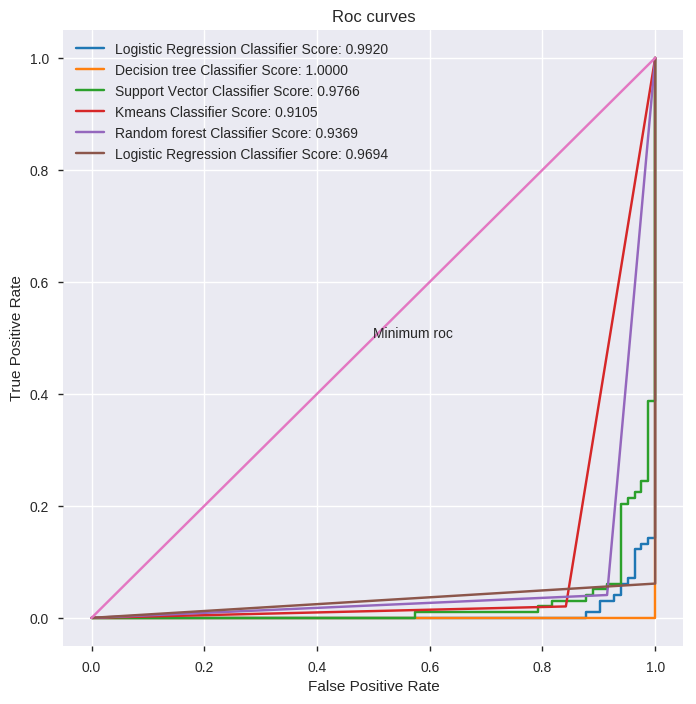

In [41]:
#Plot roc curves for the classifiers
log_tpr,log_fpr,log_thresh=roc_curve(ytrain,log_pred)
dt_tpr,dt_fpr,dt_thresh=roc_curve(ytrain,dt_pred)
sv_tpr,sv_fpr,sv_thresh=roc_curve(ytrain,svc_pred)
k_tpr,k_fpr,k_thresh=roc_curve(ytrain,k_pred)
rf_tpr,rf_fpr,rf_thresh=roc_curve(ytrain,rf_pred)
gb_tpr,gb_fpr,gb_thresh=roc_curve(ytrain,Gb_pred)

def plot_roc_curves(log_tpr,log_fpr,dt_tpr,dt_fpr,sv_tpr,sv_fpr,k_tpr,k_fpr,rf_tpr,rf_fpr,gb_tpr,gb_fpr):
    plt.figure(figsize=(8,8))
    plt.title('Roc curves')
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, log_pred)))
    plt.plot(dt_fpr, dt_tpr, label='Decision tree Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, dt_pred)))
    plt.plot(sv_fpr, sv_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, svc_pred)))
    plt.plot(k_fpr, k_tpr, label='Kmeans Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, k_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random forest Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, rf_pred)))
    plt.plot(gb_fpr, gb_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, Gb_pred)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1])
    plt.annotate('Minimum roc',xy=(0.5,0.5))
    plt.legend()
    
plot_roc_curves(log_tpr,log_fpr,dt_tpr,dt_fpr,sv_tpr,sv_fpr,k_tpr,k_fpr,rf_tpr,rf_fpr,gb_tpr,gb_fpr)
    


In [42]:
#Learning curve
def plot_learning_curves(classifier1,classifier2,classifier3,classifier4,classifier5,classifier6,x,y,ylim=None,cv=None,
                        n_jobs=1,train_sizes=np.linspace(.1, 1.0, 5)):
    f,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(ncols=2,nrows=3,sharey=True,figsize=(10,8))
    f.tight_layout()
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    #First classifier
    train_size,train_score,test_score=learning_curve(classifier1,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_mean=np.mean(train_score,axis=1)
    train_std=np.std(train_score,axis=1)
    test_mean=np.mean(test_score,axis=1)
    test_std=np.std(test_score,axis=1)
    ax1.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,alpha=0.1,color="#ff9124")
    ax1.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,alpha=0.1,color="#2492ff")
    ax1.plot(train_size,train_mean,'o-',color="#ff9124",label='Training score')
    ax1.plot(train_size,test_mean,'o-',color="#2492ff",label='Cross validation')
    ax1.set_title('LogisticRegression')
    ax1.set_xlabel('Training set')
    ax1.set_ylabel('Scores')
    ax1.grid(True)
    ax1.legend()
    #Second classifier
    train_sizes, train_scores, test_scores = learning_curve(
        classifier2, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Decision tree Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    #Third classifier
    train_size,train_score,test_score=learning_curve(classifier3,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_mean=np.mean(train_score,axis=1)
    train_std=np.std(train_score,axis=1)
    test_mean=np.mean(test_score,axis=1)
    test_std=np.std(test_score,axis=1)
    ax3.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,alpha=0.1,color="#ff9124")
    ax3.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,alpha=0.1,color="#2492ff")
    ax3.plot(train_size,train_mean,'o-',color="#ff9124",label='Training score')
    ax3.plot(train_size,test_mean,'o-',color="#2492ff",label='Cross validation')
    ax3.set_title('SVC')
    ax3.set_xlabel('Training set')
    ax3.set_ylabel('Scores')
    ax3.grid(True)
    ax3.legend()
    #Fourth classifier
    train_size,train_score,test_score=learning_curve(classifier4,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_mean=np.mean(train_score,axis=1)
    train_std=np.std(train_score,axis=1)
    test_mean=np.mean(test_score,axis=1)
    test_std=np.std(test_score,axis=1)
    ax4.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,alpha=0.1,color="#ff9124")
    ax4.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,alpha=0.1,color="#2492ff")
    ax4.plot(train_size,train_mean,'o-',color="#ff9124",label='Training score')
    ax4.plot(train_size,test_mean,'o-',color="#2492ff",label='Cross validation')
    ax4.set_title('KNeighbors')
    ax4.set_xlabel('Training set')
    ax4.set_ylabel('Scores')
    ax4.grid(True)
    ax4.legend()
    #Fifth classifier
    train_size,train_score,test_score=learning_curve(classifier5,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_mean=np.mean(train_score,axis=1)
    train_std=np.std(train_score,axis=1)
    test_mean=np.mean(test_score,axis=1)
    test_std=np.std(test_score,axis=1)
    ax5.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,alpha=0.1,color="#ff9124")
    ax5.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,alpha=0.1,color="#2492ff")
    ax5.plot(train_sizes,train_mean,'o-',color="#ff9124",label='Training score')
    ax5.plot(train_sizes,test_mean,'o-',color="#2492ff",label='Cross validation')
    ax5.set_title('RandomForest')
    ax5.set_xlabel('Training set')
    ax5.set_ylabel('Scores')
    ax5.grid(True)
    ax5.legend()
    #Sixth classifier
    train_size,train_score,test_score=learning_curve(classifier6,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_mean=np.mean(train_score,axis=1)
    train_std=np.std(train_score,axis=1)
    test_mean=np.mean(test_score,axis=1)
    test_std=np.std(test_score,axis=1)
    ax6.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,alpha=0.1,color="#ff9124")
    ax6.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,alpha=0.1,color="#2492ff")
    ax6.plot(train_size,train_mean,'o-',color="#ff9124",label='Training score')
    ax6.plot(train_size,test_mean,'o-',color="#2492ff",label='Cross validation')
    ax6.set_title('Bayes')
    ax6.set_xlabel('Training set')
    ax6.set_ylabel('Scores')
    ax6.grid(True)
    ax6.legend()

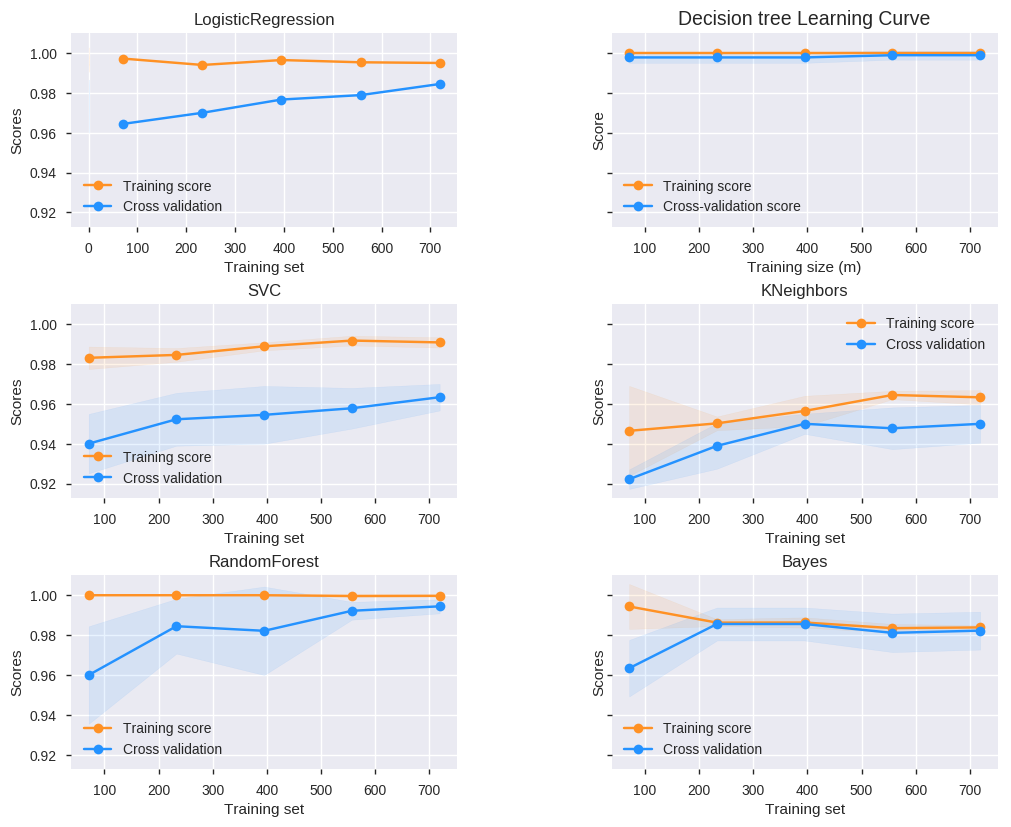

In [43]:
cv=ShuffleSplit(n_splits=100,test_size=0.2,random_state=0)
plot_learning_curves(classifiers['LogisticRegression'],classifiers['DecisionTree'],classifiers['SVC'],classifiers['KNeigbor'],classifiers['RandomForest'],
                    classifiers['Bayes'],x,y,cv=5,)

In [44]:
#Undersample during cross validation

undersample_x=cr.drop(['Class'],axis=1)
undersample_y=cr['Class']
for train_index,test_index in skf.split(undersample_x,undersample_y):
    undersample_xtrain,undersample_xtest=undersample_x.iloc[train_index],undersample_x.iloc[test_index]
    undersample_ytrain,undersample_ytest=undersample_y.iloc[train_index],undersample_y.iloc[test_index]
undersample_xtrain=undersample_xtrain.values
undersample_ytrain=undersample_ytrain.values
undersample_xtest=undersample_xtest.values
undersample_ytest=undersample_ytest.values
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
    

In [45]:
#Compute metrics
for train,test in skf.split(undersample_xtrain,undersample_ytrain):
    undersample_pipeline=imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'),classifiers['LogisticRegression']
                                                 )
    undersample_model=undersample_pipeline.fit(undersample_xtrain[train],undersample_ytrain[train])
    
    undersample_prediction=undersample_model.predict(undersample_xtrain[test])
    
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))
    undersample_accuracy.append(undersample_pipeline.score(original_xtrain[test], original_ytrain[test]))
    

In [46]:
# Results for correct cross validation

print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))




Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.93
F1 Score: 0.01


In [47]:
#Overfitting due to undersampling before cross validation
y_pred=classifiers['LogisticRegression'].predict(xtrain)
print('Recall Score: {:.2f}'.format(recall_score(ytrain, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(ytrain, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(ytrain, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(ytrain, y_pred)))


Recall Score: 0.95
Precision Score: 0.65
F1 Score: 0.77
Accuracy Score: 0.74


In [48]:
#Average precision recall score
average_precision_score(original_ytrain[test], undersample_prediction)

0.003900000622525972

# 5.0 SMOTE

In [49]:
#Logistic regression
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)



for train, test in skf.split(original_xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_xtrain[train], original_ytrain[train])
    best_est_log = rand_log_reg.best_estimator_
    prediction = best_est_log.predict(original_xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

Length of X (train): 226982 | Length of y (train): 226982
Length of X (test): 56744 | Length of y (test): 56744


In [50]:
#classification report
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est_log.predict(original_xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56650
       Fraud       0.06      0.86      0.12        94

   micro avg       0.98      0.98      0.98     56744
   macro avg       0.53      0.92      0.55     56744
weighted avg       1.00      0.98      0.99     56744



In [69]:
#predict
best_est_log.predict([[-2.312227,
              1.951992,
             -1.609851,
              3.997906,
            -0.522188,
            -1.426545,
             -2.537387,
              1.391657,
             -2.770089,
             -2.772272,
             3.202033,
            -2.899907,
             -0.595222,
             -4.289254,
              0.389724,
            -1.140747,
             -2.830056,
            -0.016822,
              0.416956,
              0.126911,
             0.517232,
             -0.035049,
             -0.465211,
              0.320198,
              0.044519,
              0.177840,
              0.261145,
             -0.143276,
           -0.353327 ,
                       -1.9882]])

array([1])

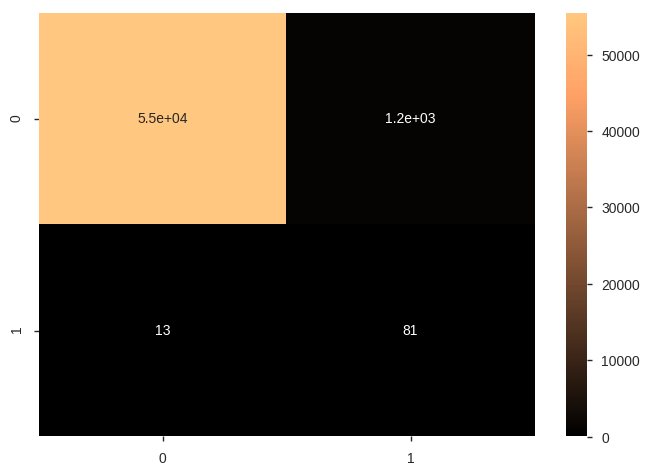

In [53]:
#Confusion matrix
log_reg_cf=confusion_matrix(original_ytest, smote_prediction)
sns.heatmap(log_reg_cf, annot=True, cmap=plt.cm.copper)



In [70]:
#save model
joblib.dump(best_est_log,'credit.joblib')

['credit.joblib']